In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import os
#import tqdm
import random
import sys
import os
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("muted")
# 修改工作路径，使本.ipynb文件能够像在本文件夹根目录下一样导入其他模块
# Modify the working path so that this.ipynb file can import other modules like in the root directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(current_dir, '..'))

In [2]:
data=pd.read_excel("E:\科创优才\实验数据\毕设实验数据\\testo20240511数据.xlsx")

In [3]:
data.columns

Index(['日期／时间', '运行时间', '% O2', 'ppm CO', '% CO2', 'ppm NO', 'ppm NO2',
       '°C 烟温', 'ppm NOx', 'ppm SO2', '% 净效率', '% 毛效率', '°C 环温', 'l/min 泵流量',
       '稀释倍数'],
      dtype='object')

In [4]:
X1=data[['% O2', 'ppm CO', '% CO2', 'ppm NO', 'ppm NO2',
       '°C 烟温', 'ppm NOx', 'ppm SO2', '°C 环温', 'l/min 泵流量',]].to_numpy()

In [5]:
X1.shape

(8602, 10)

In [6]:
X=[]
Y=[]
for i in range(0,8500,100):
    X.append(X1[i:i+100])
    Y.append(X1[i+100:i+120])
X=np.array(X)
Y=np.array(Y)
print(X.shape)
print(Y.shape)



(85, 100, 7)
(85, 20, 7)


In [10]:
from models.RNN import RNN, LSTM, GRU
from models.CNN import CNN, TCN
from models.MLP import MLP
#from models.transformer import Transformer, iTransformer, PatchTST, Reformer, Informer
from models.Linear import LLinear, DLinear, NLinear
from models.stat import Identical, ExponentialMovingAverage, SVR
from flight_data_prediction.utils import FitHistory

# 超参数
num_epochs = 10  # 训练的轮数
learning_rate = 0.001 # 学习率
input_len = 100  # 输入长度
output_len = 20  # 输出长度
label_len = 8 # 标签长度
input_channels = 7  # 输入通道数
output_channels = 7  # 输出通道数
batch_size = 64  # 批大小
#device = 'cpu'  # 设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 实例化模型、损失函数、评估函数和优化器
MODEL = CNN(
    input_len=input_len, output_len=output_len, input_channels=input_channels, output_channels=output_channels,
    ).to(device)
loss_func = nn.MSELoss()
metric_func=nn.L1Loss()
optimizer = optim.Adam(MODEL.parameters(), lr=learning_rate)
history=FitHistory()
print('Model parameters: ', sum(p.numel() for p in MODEL.parameters()))

Model parameters:  115788


In [8]:
import flight_data_prediction.data_preprocessing as dp
train_loader, val_loader, test_loader = dp.get_XY_loaders(X, Y, batch_size=batch_size)

Train dataset size: X: (59, 100, 7); Y: (59, 20, 7)
Val dataset size: X: (8, 100, 7); Y: (8, 20, 7)
Test dataset size: X: (17, 100, 7); Y: (17, 20, 7)


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

Epoch [ 1  /10], Time: 2.4989s, Loss: 276.9987, Metric: 11.3676, Val Loss: 270.5340, Val Metric: 11.2644
Epoch [ 2  /10], Time: 0.0052s, Loss: 268.6142, Metric: 11.0974, Val Loss: 259.2054, Val Metric: 10.9608
Epoch [ 3  /10], Time: 0.0055s, Loss: 259.2039, Metric: 10.8529, Val Loss: 245.5707, Val Metric: 10.6846
Epoch [ 4  /10], Time: 0.0041s, Loss: 247.4392, Metric: 10.6089, Val Loss: 229.2040, Val Metric: 10.4587
Epoch [ 5  /10], Time: 0.0044s, Loss: 232.8817, Metric: 10.3782, Val Loss: 209.8287, Val Metric: 10.1905
Epoch [ 6  /10], Time: 0.0045s, Loss: 215.2025, Metric: 10.0869, Val Loss: 187.2463, Val Metric: 9.8150
Epoch [ 7  /10], Time: 0.0057s, Loss: 194.1015, Metric: 9.7197, Val Loss: 162.1355, Val Metric: 9.2961
Epoch [ 8  /10], Time: 0.0039s, Loss: 169.9240, Metric: 9.2595, Val Loss: 135.8841, Val Metric: 8.6340
Epoch [ 9  /10], Time: 0.0046s, Loss: 143.3870, Metric: 8.6769, Val Loss: 110.5032, Val Metric: 7.8374
Epoch [ 10 /10], Time: 0.0056s, Loss: 115.6851, Metric: 7.9718

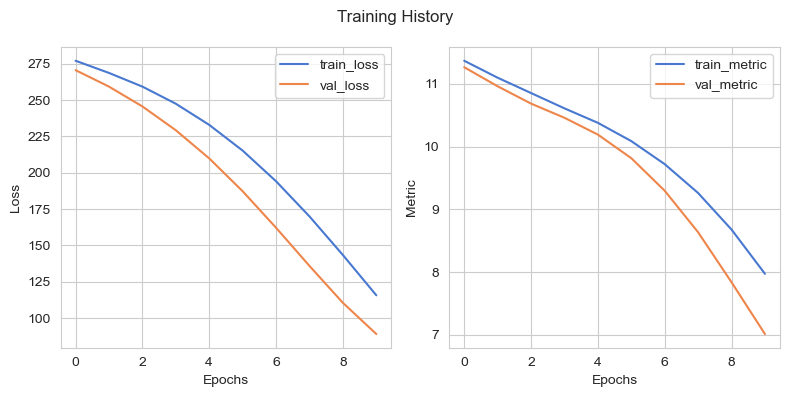

Number of epochs:  10
Training time:     2.5425s
Training loss:     115.6851
Training metric:   7.9718
Validation loss:   89.0501
Validation metric: 7.0118


In [11]:
from flight_data_prediction.utils import train
# 训练模型
history.update(
            *train(MODEL, train_loader, val_loader, optimizer,
                loss_func=nn.MSELoss(),
                metric_func=nn.L1Loss(),
                num_epochs=10,
                device=device,
                verbose=1)
            )
history.plot()
history.summary()